# Data_Checker

### 목적
- 일단 step별로 데이터 저장하기
- 제외시킬 데이터 확인하기
- 제외시킬 데이터 자동으로 제외시키기
- 제외시킬 데이터는 "20220325_raw_byDeepak_csv" 폴더 안에 있음

### 출력 예제
- Data_Checked
    - list of data.xlsx
    - [folder] include
    - [folder] exclude 

In [1]:
# import 필요한 라이브러리
import os
from natsort import natsorted
from pathlib import Path
import shutil
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# 필요한 함수 선언
def ensure_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)


# 제외_길이미달 및 step-wise 저장 
- 데이터 중에 길이 미달인놈 제외함
- 데이터 중 1 step과 2step짜리로 분류해서 저장

In [5]:
# 우선 데이터를 step별로 나누기

# 전체 데이터 목록 불러오기
# target directory 지정
dataDir =       r"Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv"
rawDir =        r"Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\RAW"
includeDir =    r"Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\INC_ByStep\RAW"
excludeDir =    r"Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\EXC"
dataExt = r".csv"


In [6]:

# 파일 목록없으면 만들기
ensure_dir(includeDir)
ensure_dir(excludeDir)

# 파일 목록 전체 들고오고 필요한 확장자만 고르고 들고온 파일 목록에서 .txt만 남기고 나머지 것들 제외시키기
dataList = natsorted([_ for _ in os.listdir(rawDir) if _.endswith(dataExt)])
excluded_len = [] #제외된 경우 1이라고 표기
# 전체 파일 순환 하면서 제외 조건 찾기
# 1) 전체 데이터가 잘 있는가? 최소한 한 step 이상 IMU랑 mechanics data가 잘 있는지 (최소 75 columns)
# 2) 전체 데이터에 0이 반복되는 것이 있는지?
Num_column_start = 2 # 2칸 후에 시작, 그러니까 빈 column이 2개
for datum in tqdm(dataList):
    # 개별 파일 읽기
    read_file = pd.read_csv(os.path.join(rawDir, datum))
    # 1) 제외하는 것 찾기
    if (len(read_file.columns)-2) % 75 == 0 and (len(read_file.columns)-2) // 75 > 0:
        # 데이터의 col이 75의 배수일 때 = 데이터가 잘 정리되어 있을 때
        MAXstepCount = (len(read_file.columns)-2) // 75 # 최대 step수를 측정
        for stepcount in range(0,MAXstepCount):
            # 원하는 데이터
            DFperStep_imu = read_file.iloc[:,[idx*MAXstepCount+stepcount+Num_column_start for idx in range(0,63)]]
            DFperStep_SD = read_file.iloc[:, [(63*MAXstepCount)+idx+stepcount*3+Num_column_start for idx in range(0,12*(MAXstepCount)) if idx%(3*MAXstepCount) <3]]
            DFperStep = pd.concat([DFperStep_imu, DFperStep_SD],axis=1).dropna(how='all')
            # 저장용 이름 만들기
            nametoSave  = datum.split(".")[0] + "_"+str(stepcount+1) + "_Step.csv"
            # 저장하기
            DFperStep.to_csv(os.path.join(includeDir,nametoSave),index=False)

        # 2) 데이터 정리된 것 중 잘린 데이터 찾기 = 0이 반복적으로 나와있는 것
        excluded_len.append(stepcount+1)
    else:
        # 저장하기
        read_file.to_csv(os.path.join(excludeDir,datum),index=False)
        excluded_len.append(0)


listofname = pd.DataFrame(dataList,columns=["fileName"])
listofExcluded = pd.DataFrame(excluded_len,columns=["No. of Included"])
result = pd.concat([listofname,listofExcluded],axis=1)
numofexcluded = (listofExcluded[listofExcluded.columns[0]] == 0).sum()
numofonestep = (listofExcluded[listofExcluded.columns[0]] == 1).sum()
numoftwostep = (listofExcluded[listofExcluded.columns[0]] == 2).sum()
result.to_excel(os.path.join(dataDir,"list_Excluded_DataByStep.xlsx"))

  0%|          | 0/1304 [00:00<?, ?it/s]

In [123]:
# 데이터 확인용
Numtotal = numofexcluded+numofonestep+numoftwostep
print(f"No. Excluded: {numofexcluded} \nNo. 1 step Included: {numofonestep} \nNo. 2 step Included: {numoftwostep} \nNo. total(verify): {Numtotal} \nNo. total(truevl): {len(dataList)}")
print("==========================")
print(f"INC_ByStep contain {numofonestep + 2*numoftwostep} file = No. 1 step included + 2 * No. 2 step included(s)")

No. Excluded: 391 
No. 1 step Included: 828 
No. 2 step Included: 85 
No. total(verify): 1304 
No. total(truevl): 1304
INC_ByStep contain 998 file(s)


# 제외_0만 가득 찬 columns

In [7]:
# Step 별로 잘라진 데이터에서 0만 포함된 columns이 있는 데이터는 제외시키기
# https://stackoverflow.com/questions/21164910/how-do-i-delete-a-column-that-contains-only-zeros-in-pandas
# step 별로 분류된 파일 위치
dataDir =       r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\INC_ByStep'
rawDir =        r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\INC_ByStep\RAW'
includeDir =    r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\INC_ByStep\INC_ByZero\RAW'
excludeDir =    r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\INC_ByStep\EXC'

ensure_dir(includeDir)
ensure_dir(excludeDir)

dataExt = r".csv"
# 파일 목록 전체 들고오고 필요한 확장자만 고르고 들고온 파일 목록에서 .txt만 남기고 나머지 것들 제외시키기
dataList = natsorted([_ for _ in os.listdir(rawDir) if _.endswith(dataExt)])
excluded_zero = []
for datum in tqdm(dataList):
    # 개별 파일 읽기

    read_file = pd.read_csv(os.path.join(rawDir, datum))
    tmp = read_file.iloc[4:,:].copy()
    tmp = tmp.astype(float)
    tmp = tmp.loc[:,(tmp !=0).any(axis=0)]

    if (len(tmp.columns)) % 75 == 0 and (len(tmp.columns)) // 75 > 0:
        read_file.to_csv(os.path.join(includeDir,datum),index=False)
        excluded_zero.append(1)
    else:
        read_file.to_csv(os.path.join(excludeDir,datum),index=False)
        excluded_zero.append(0)

listofname = pd.DataFrame(dataList,columns=["fileName"])
listofExcluded = pd.DataFrame(excluded_zero,columns=["No. of Included"])
numofexcluded = (listofExcluded[listofExcluded.columns[0]] == 0).sum()
numofincluded = (listofExcluded[listofExcluded.columns[0]] == 1).sum()
result = pd.concat([listofname,listofExcluded],axis=1)
result.to_excel(os.path.join(dataDir,"list_Excluded_byZero.xlsx"))

  0%|          | 0/998 [00:00<?, ?it/s]

In [8]:
Numtotal = numofexcluded+numofincluded
print(f"No. Excluded: {numofexcluded} \nNo.Included: {numofincluded} \nNo. total(verify): {Numtotal} \nNo. total(truevl): {len(dataList)}")
print("==========================")
print(f"includ folder contain {numofincluded} file(s)")

No. Excluded: 95 
No.Included: 903 
No. total(verify): 998 
No. total(truevl): 998
includ folder contain 903 file(s)


# 밟은 발에 따른 축 변환

- oaleg - R : 오른발 moment 측정
- oaleg - L : 왼발   moment 측정
- nonleg- R : 왼발   moment 측정
- nonleg- L : 오른발 moment 측정

In [5]:
rawDir =        r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\INC_ByStep\INC_ByZero\RAW'
targetDir =    r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\INC_ByStep\INC_ByZero\AXIS_correction'

In [6]:
def nonlegisLeft(sideInfo):
    if (sideInfo == 'R'):
        return True
    else:
        return False

In [6]:
ensure_dir(targetDir)

dataExt = r".csv"
# 파일 목록 전체 들고오고 필요한 확장자만 고르고 들고온 파일 목록에서 .txt만 남기고 나머지 것들 제외시키기
dataList = natsorted([_ for _ in os.listdir(rawDir) if _.endswith(dataExt)])
excluded_zero = []
for datum in tqdm(dataList):
    # 개별 파일 읽기

    read_file = pd.read_csv(os.path.join(rawDir, datum))
    read_file.iloc[4:,:] = read_file.iloc[4:,:].astype(float)
    sideInfo = datum.split('_')[-3]
    legInfo = datum.split('_')[4]
    # nonleg가 왼발일 경우
    if nonlegisLeft(sideInfo):
        targetcol = [_ for _ in range(0,27) if not (((_%9 >0) and (_%9<4)) or ((_%9 >5) and (_%9<9)))]
        for col in targetcol:
            read_file.iloc[4:,col]   = read_file.iloc[4:,col].apply(lambda x:x*-1)
        # nonleg의 데이터를 변경한다!
    
    # nonleg가 왼발이 아닐경우
    else:
        targetcol = [_ + 27 for _ in range(0,27) if not (((_%9 >0) and (_%9<4)) or ((_%9 >5) and (_%9<9)))]
        for col in targetcol:
            read_file.iloc[4:,col]   = read_file.iloc[4:,col].apply(lambda x:x*-1)
        # oaleg의 데이터를 변경한다!
    read_file.to_csv(os.path.join(targetDir,datum),index=False)


  0%|          | 0/903 [00:00<?, ?it/s]

# 그리기_PDF for 육안 확인
-  육안으로 확인하기 위한 PDF그리기

In [7]:
# 필요한 함수 정의
def axis3plot(position,data,name):
    subAJ_right = 0.5
    subAJ_top = 1.5
    subAJ_wspace = 0.5
    sub_offset= 40

    data = data.astype(float)
    
    host = host_subplot(position, axes_class=AA.Axes)
    plt.subplots_adjust(right=subAJ_right,top=subAJ_top, wspace=subAJ_wspace)

    par1 = host.twinx()
    par2 = host.twinx()

    offset = sub_offset
    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["right"] = new_fixed_axis(loc="right",
                                        axes=par2,
                                        offset=(offset, 0))

    par1.axis["right"].toggle(all=True) 
    par2.axis["right"].toggle(all=True)

    # host.set_xlim(0, 2)
    # host.set_ylim(0, 2)

    host.set_xlabel(f"Time/{name}")
    # host.set_ylabel("X_axis")
    # par1.set_ylabel("Y_axis")
    # par2.set_ylabel("Z_axis")

    p1, = host.plot(range(0,len(data)), np.array(data.iloc[:,0]), label="X_axis")
    p2, = par1.plot(range(0,len(data)),  np.array(data.iloc[:,1]), label="Y_axis")
    p3, = par2.plot(range(0,len(data)),  np.array(data.iloc[:,2]), label="Z_axis")

    # par1.set_ylim(0, 4)
    # par2.set_ylim(1, 65)

    host.legend()

    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    par2.axis["right"].label.set_color(p3.get_color())

    host.axis["left"].major_ticks.set_color(p1.get_color())
    par1.axis["right"].major_ticks.set_color(p2.get_color())
    par2.axis["right"].major_ticks.set_color(p3.get_color())

    host.axis["left"].major_ticklabels.set_color(p1.get_color())
    par1.axis["right"].major_ticklabels.set_color(p2.get_color())
    par2.axis["right"].major_ticklabels.set_color(p3.get_color())

In [13]:
# 이미지를 그려놓고 제외할 데이터를 보고 판단하기
# 여기서는 이미지 그려놓는 것 까지만 하자
# 이미지 보고 제끼는 거는 .py로 따로 짜기

# 필요한 dir 정의
dataDir =       r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\INC_ByStep\INC_ByZero'
rawDir =        r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\INC_ByStep\INC_ByZero\AXIS_correction'
figDir =        r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\INC_ByStep\INC_ByZero\FIG'
includeDir =    r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\INC_ByStep\INC_ByZero\Included_checked\RAW'
excludeDir =    r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\INC_ByStep\INC_ByZero\EXC'

ensure_dir(figDir)
ensure_dir(includeDir)
ensure_dir(excludeDir)

dataExt = r".csv"
# 파일 목록 전체 들고오고 필요한 확장자만 고르고 들고온 파일 목록에서 .txt만 남기고 나머지 것들 제외시키기
dataList = natsorted([_ for _ in os.listdir(rawDir) if _.endswith(dataExt)])
excluded_zero = []
for datum in tqdm(dataList):
    # 데이터 읽기
    read_file = pd.read_csv(os.path.join(rawDir, datum))
    # #Figure 그리기
    # #음..나도 pdf로 그려볼까..?
    # # region
    # 해당 파일이 있으면
    if not os.path.exists(os.path.join(figDir,f'{datum.split(".")[0]}.pdf')):
        pp = PdfPages(os.path.join(figDir,f'{datum.split(".")[0]}.pdf'))
        ################################# 1page ###############
        plt.figure(figsize=(15, 8))
        for i in range(0,9):
            axis3plot(331+i,read_file.iloc[4:,3*i:3+i*3], '_'.join(read_file.iloc[0,3*i:3+i*3][0].split('_')[:-1]))
        plt.tight_layout()
        pp.savefig()
        plt.close()
        ################################# 2page ###############
        # 시작 column 위치
        col_startForFig = 27
        plt.figure(figsize=(15, 8))
        for i in range(0,9):
            axis3plot(331+i,read_file.iloc[4:,col_startForFig+3*i:col_startForFig+3+i*3], '_'.join(read_file.iloc[0,col_startForFig+3*i:col_startForFig+3+i*3][0].split('_')[:-1]))
        plt.tight_layout()
        pp.savefig()
        plt.close()
        ################################# 3page ###############
        # 시작 column 위치
        col_startForFig = 54
        plt.figure(figsize=(15, 8))
        for i in range(0,3):
            axis3plot(331+i,read_file.iloc[4:,col_startForFig+3*i:col_startForFig+3+i*3], '_'.join(read_file.iloc[0,col_startForFig+3*i:col_startForFig+3+i*3][0].split('_')[:-1]))
        plt.tight_layout()
        pp.savefig()
        plt.close()
        ################################# 4page ###############
        col_startForFig = 63
        plt.figure(figsize=(15, 8))
        for i in range(0,4):
            axis3plot(331+i,read_file.iloc[4:,col_startForFig+3*i:col_startForFig+3+i*3], '_'.join(read_file.iloc[0,col_startForFig+3*i:col_startForFig+3+i*3][0].split('_')[:-1]))
        plt.tight_layout()
        pp.savefig()
        plt.close()
        ##############################다 출력한 후#############################################
        pp.close()
        # 903 개를 pdf만드는데 2시간 걸리는데 이거 맞나....
        # 처리속도는 얼마 안걸리는데, 이게 인터넷이 느려서 데이터 읽고 쓰는 시간이 큰듯
        # #하나당 3초정도?
  

  0%|          | 0/903 [00:00<?, ?it/s]

# 끝

### 왜 원래꺼(908개)랑 새로 만든거(903개)가 크기가 다르지..?
- 데이터 개수는 903개가 맞는데
- 원래꺼에 5개의 데이터가 들어가있네
- 범인을 찾아보자!

In [44]:
allnew = r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\INC_ByStep\INC_ByZero\FIG'
origin = r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\20220325_raw_byDeepak_csv\INC_ByStep\INC_ByZero\FIG'

dataExt = r".pdf"
# 파일 목록 전체 들고오고 필요한 확장자만 고르고 들고온 파일 목록에서 .txt만 남기고 나머지 것들 제외시키기
allnewdataList = natsorted([_ for _ in os.listdir(allnew) if _.endswith(dataExt)])
origindataList = natsorted([_ for _ in os.listdir(origin) if _.endswith(dataExt)])

In [50]:
str_name = np.array(allnewdataList[0].split('_'))
str_name  = np.delete(str_name, -3)
str_name = '_'.join(str_name)
str_name

'P002_031220_w_0007_nonleg_imu_knee_angle_moment_1_Step.pdf'

In [60]:
renamed = []
for data in allnewdataList:
    str_name = np.array(data.split('_'))
    str_name  = np.delete(str_name, -3)
    str_name = '_'.join(str_name)
    renamed.append(str_name)


In [61]:
set(origindataList) ^ set(renamed)

{'P258_111819_w_0003_nonleg_imu_knee_angle_moment_L_2_Step.pdf',
 'P258_111819_w_0003_oaleg_imu_knee_angle_moment_L_1_Step.pdf',
 'P258_111819_w_0007_nonleg_imu_knee_angle_moment_L_1_Step.pdf',
 'P258_111819_w_0007_oaleg_imu_knee_angle_moment_L_1_Step.pdf',
 'P258_111819_w_0009_nonleg_imu_knee_angle_moment_L_1_Step.pdf'}

# Supplementary_이번에 새로 배운 코드

In [120]:
############# 확장성을 가진 코드!!
## 해냈당!
Num_column_start = 2
MAXstepCount = 3
stepcount=2 # 0부터 시작
[(63*MAXstepCount)+idx+stepcount*3+Num_column_start for idx in range(0,12*(MAXstepCount)) if idx%(3*MAXstepCount) <3]

[197, 198, 199, 206, 207, 208, 215, 216, 217, 224, 225, 226]

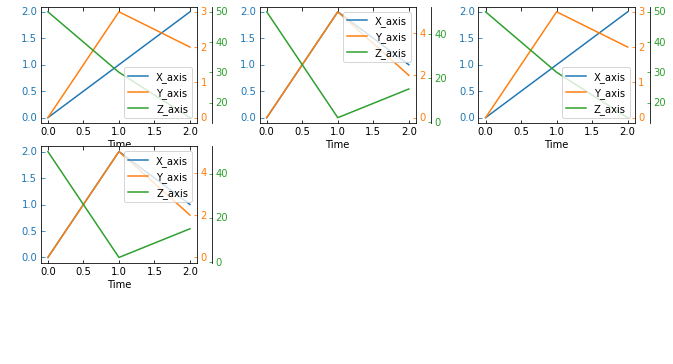

In [1]:
# https://matplotlib.org/3.5.0/gallery/axisartist/demo_parasite_axes2.html
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# region
subAJ_right = 1.5
subAJ_top = 1.5
subAJ_wspace = 0.4
sub_offset= 15

host = host_subplot(331, axes_class=AA.Axes)
plt.subplots_adjust(right=subAJ_right,top=subAJ_top, wspace=subAJ_wspace)

par1 = host.twinx()
par2 = host.twinx()

offset = sub_offset
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))

par1.axis["right"].toggle(all=True) 
par2.axis["right"].toggle(all=True)

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)

host.set_xlabel("Time")
# host.set_ylabel("X_axis")
# par1.set_ylabel("Y_axis")
# par2.set_ylabel("Z_axis")

p1, = host.plot([0, 1, 2], [0, 1, 2], label="X_axis")
p2, = par1.plot([0, 1, 2], [0, 3, 2], label="Y_axis")
p3, = par2.plot([0, 1, 2], [50, 30, 15], label="Z_axis")

# par1.set_ylim(0, 4)
# par2.set_ylim(1, 65)

host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())

host.axis["left"].major_ticks.set_color(p1.get_color())
par1.axis["right"].major_ticks.set_color(p2.get_color())
par2.axis["right"].major_ticks.set_color(p3.get_color())

host.axis["left"].major_ticklabels.set_color(p1.get_color())
par1.axis["right"].major_ticklabels.set_color(p2.get_color())
par2.axis["right"].major_ticklabels.set_color(p3.get_color())

host = host_subplot(332, axes_class=AA.Axes)
plt.subplots_adjust(right=subAJ_right,top=subAJ_top, wspace=subAJ_wspace)


par1 = host.twinx()
par2 = host.twinx()

offset = sub_offset
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))

par1.axis["right"].toggle(all=True) 
par2.axis["right"].toggle(all=True)

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)

host.set_xlabel("Time")
# host.set_ylabel("X_axis")
# par1.set_ylabel("Y_axis")
# par2.set_ylabel("Z_axis")

p1, = host.plot([0, 1, 2], [0, 2, 1], label="X_axis")
p2, = par1.plot([0, 1, 2], [0, 5, 2], label="Y_axis")
p3, = par2.plot([0, 1, 2], [50, 2, 15], label="Z_axis")

# par1.set_ylim(0, 4)
# par2.set_ylim(1, 65)

host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())

host.axis["left"].major_ticks.set_color(p1.get_color())
par1.axis["right"].major_ticks.set_color(p2.get_color())
par2.axis["right"].major_ticks.set_color(p3.get_color())

host.axis["left"].major_ticklabels.set_color(p1.get_color())
par1.axis["right"].major_ticklabels.set_color(p2.get_color())
par2.axis["right"].major_ticklabels.set_color(p3.get_color())

host = host_subplot(333, axes_class=AA.Axes)
plt.subplots_adjust(right=subAJ_right,top=subAJ_top, wspace=subAJ_wspace)

par1 = host.twinx()
par2 = host.twinx()

offset = sub_offset
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))

par1.axis["right"].toggle(all=True) 
par2.axis["right"].toggle(all=True)

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)

host.set_xlabel("Time")
# host.set_ylabel("X_axis")
# par1.set_ylabel("Y_axis")
# par2.set_ylabel("Z_axis")

p1, = host.plot([0, 1, 2], [0, 1, 2], label="X_axis")
p2, = par1.plot([0, 1, 2], [0, 3, 2], label="Y_axis")
p3, = par2.plot([0, 1, 2], [50, 30, 15], label="Z_axis")

# par1.set_ylim(0, 4)
# par2.set_ylim(1, 65)

host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())

host.axis["left"].major_ticks.set_color(p1.get_color())
par1.axis["right"].major_ticks.set_color(p2.get_color())
par2.axis["right"].major_ticks.set_color(p3.get_color())

host.axis["left"].major_ticklabels.set_color(p1.get_color())
par1.axis["right"].major_ticklabels.set_color(p2.get_color())
par2.axis["right"].major_ticklabels.set_color(p3.get_color())

host = host_subplot(334, axes_class=AA.Axes)
plt.subplots_adjust(right=subAJ_right,top=subAJ_top, wspace=subAJ_wspace)


par1 = host.twinx()
par2 = host.twinx()

offset = sub_offset
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))

par1.axis["right"].toggle(all=True) 
par2.axis["right"].toggle(all=True)

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)

host.set_xlabel("Time")
# host.set_ylabel("X_axis")
# par1.set_ylabel("Y_axis")
# par2.set_ylabel("Z_axis")

p1, = host.plot([0, 1, 2], [0, 2, 1], label="X_axis")
p2, = par1.plot([0, 1, 2], [0, 5, 2], label="Y_axis")
p3, = par2.plot([0, 1, 2], [50, 2, 15], label="Z_axis")

# par1.set_ylim(0, 4)
# par2.set_ylim(1, 65)

host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())

host.axis["left"].major_ticks.set_color(p1.get_color())
par1.axis["right"].major_ticks.set_color(p2.get_color())
par2.axis["right"].major_ticks.set_color(p3.get_color())

host.axis["left"].major_ticklabels.set_color(p1.get_color())
par1.axis["right"].major_ticklabels.set_color(p2.get_color())
par2.axis["right"].major_ticklabels.set_color(p3.get_color())

plt.tight_layout()

ressult_fig = plt.draw()
# plt.show()
pp = PdfPages(os.path.join(r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\20220325_raw_byDeepak_csv\INC_ByStep\INC_ByZero\FIG','line_plot.pdf'))
pp.savefig(ressult_fig)
pp.close()
# plt.savefig


C:\Users\orien\anaconda3\envs\BUreg\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


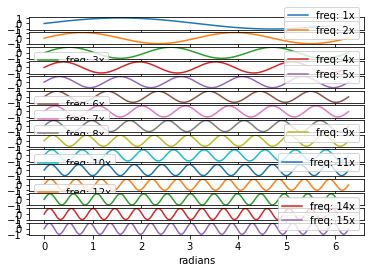

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sinusoidal sample data
sample_length = range(1, 15+1)
rads = np.arange(0, 2*np.pi, 0.01)
data = np.array([np.sin(t*rads) for t in sample_length])
df = pd.DataFrame(data.T, index=pd.Series(rads.tolist(), name='radians'), columns=[f'freq: {i}x' for i in sample_length])


# default plot with subplots; each column is a subplot
axes = df.plot(subplots=True)

C:\Users\orien\anaconda3\envs\BUreg\lib\site-packages\ipykernel_launcher.py:10: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  # Remove the CWD from sys.path while we load stuff.


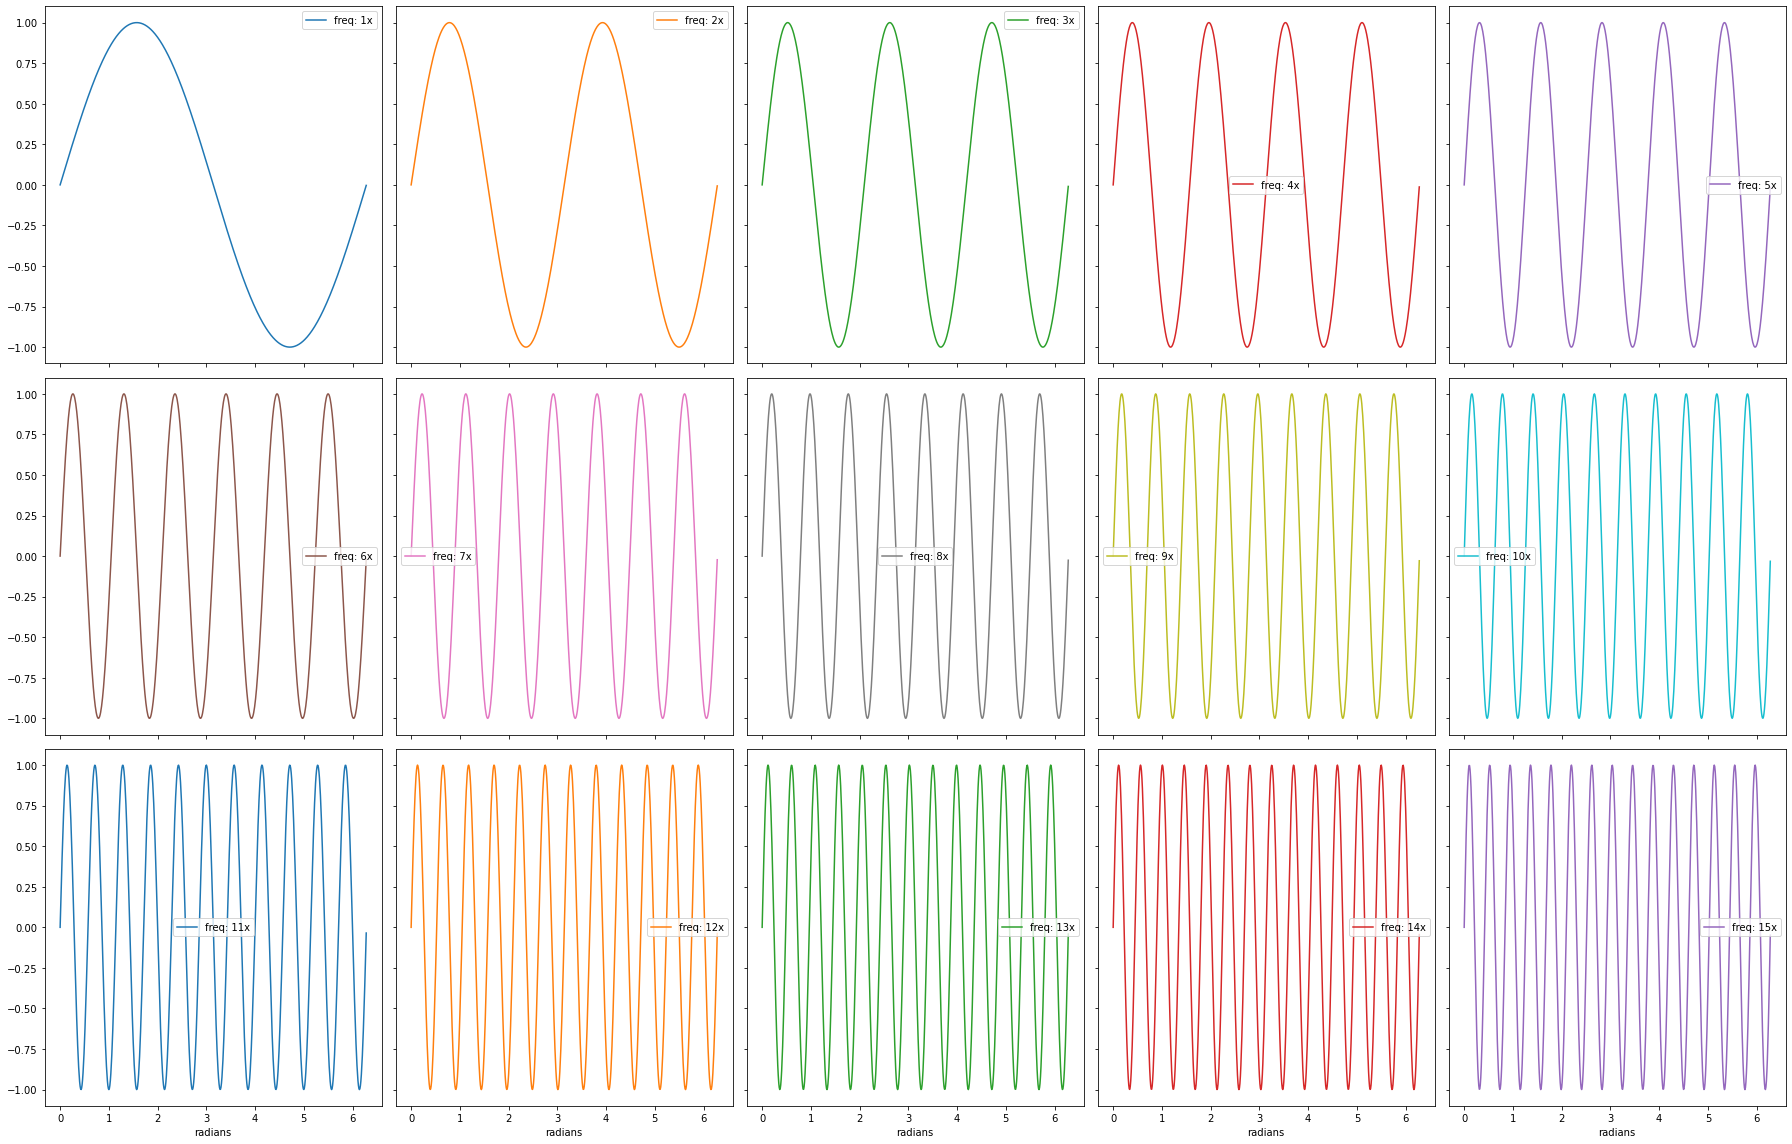

In [226]:
axes = df.plot(subplots=True, layout=(3, 5), figsize=(25, 16), sharex=True, sharey=True)

# flatten the axes array to easily access any subplot
axes = axes.flat

# extract the figure object
fig = axes[0].get_figure()

# use tight_layout
fig.tight_layout()

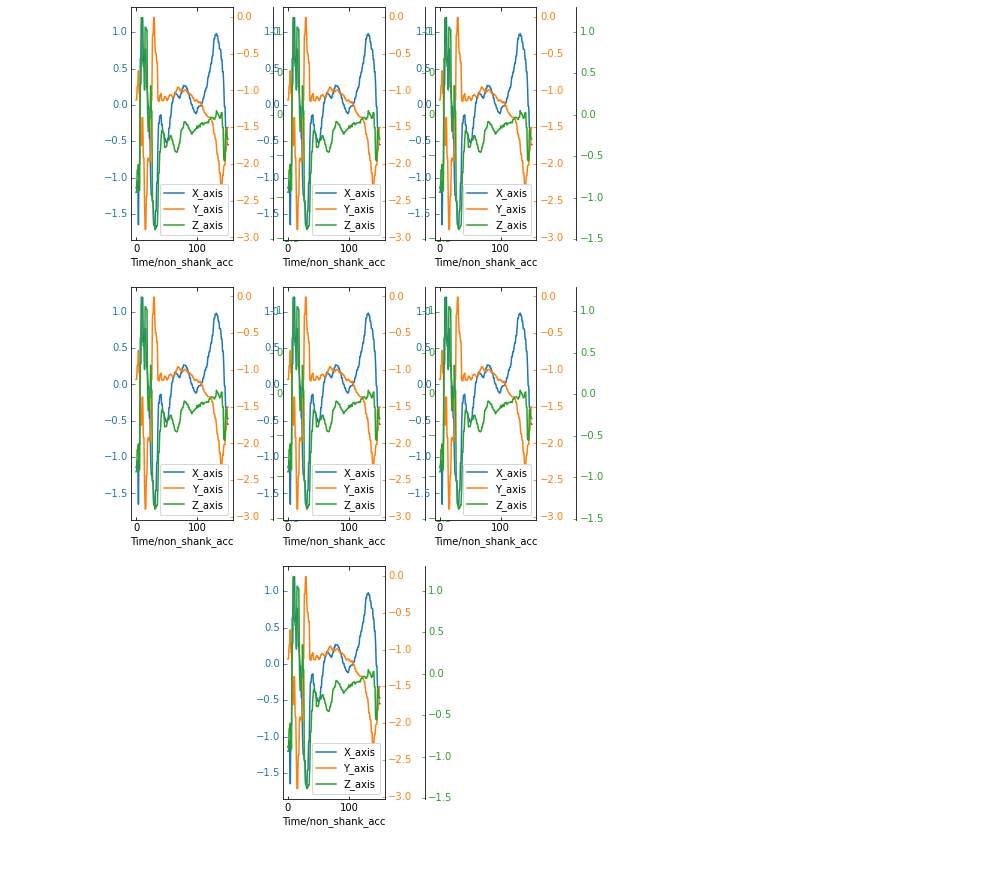

In [91]:
# 함수화
def axis3plot(position,data,name):
    subAJ_right = 0.5
    subAJ_top = 1.5
    subAJ_wspace = 0.5
    sub_offset= 40

    data = data.astype(float)
    
    host = host_subplot(position, axes_class=AA.Axes)
    plt.subplots_adjust(right=subAJ_right,top=subAJ_top, wspace=subAJ_wspace)

    par1 = host.twinx()
    par2 = host.twinx()

    offset = sub_offset
    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["right"] = new_fixed_axis(loc="right",
                                        axes=par2,
                                        offset=(offset, 0))

    par1.axis["right"].toggle(all=True) 
    par2.axis["right"].toggle(all=True)

    # host.set_xlim(0, 2)
    # host.set_ylim(0, 2)

    host.set_xlabel(f"Time/{name}")
    # host.set_ylabel("X_axis")
    # par1.set_ylabel("Y_axis")
    # par2.set_ylabel("Z_axis")

    p1, = host.plot(range(0,len(data)), np.array(data.iloc[:,0]), label="X_axis")
    p2, = par1.plot(range(0,len(data)),  np.array(data.iloc[:,1]), label="Y_axis")
    p3, = par2.plot(range(0,len(data)),  np.array(data.iloc[:,2]), label="Z_axis")

    # par1.set_ylim(0, 4)
    # par2.set_ylim(1, 65)

    host.legend()

    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    par2.axis["right"].label.set_color(p3.get_color())

    host.axis["left"].major_ticks.set_color(p1.get_color())
    par1.axis["right"].major_ticks.set_color(p2.get_color())
    par2.axis["right"].major_ticks.set_color(p3.get_color())

    host.axis["left"].major_ticklabels.set_color(p1.get_color())
    par1.axis["right"].major_ticklabels.set_color(p2.get_color())
    par2.axis["right"].major_ticklabels.set_color(p3.get_color())

plt.figure(figsize=(15, 8))
axis3plot(331,non_shank_acc,'non_shank_acc')
axis3plot(332,non_shank_acc,'non_shank_acc')
axis3plot(333,non_shank_acc,'non_shank_acc')
axis3plot(334,non_shank_acc,'non_shank_acc')
axis3plot(335,non_shank_acc,'non_shank_acc')
axis3plot(336,non_shank_acc,'non_shank_acc')
axis3plot(338,non_shank_acc,'non_shank_acc')
plt.tight_layout()

ressult_fig = plt.draw()
# plt.show()
pp = PdfPages(os.path.join(r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\20220325_raw_byDeepak_csv\INC_ByStep\INC_ByZero\FIG','line_plot.pdf'))
pp.savefig(ressult_fig)
pp.close()

In [10]:
import re
A = 'W002_20210715_isok_concon60_0001_Miqus_21_25762.avi'
p = re.compile(r'_([0-9]{5})\.')
p.search(A)[0][1:-1]

'25762'